In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

### Setting Up Primitives and Functions for Demonstrating Convex Hull algorithms

Generating X and Y Coordinates

In [44]:
num_points = 15

rng = np.random.default_rng()

x = rng.integers(0, 50, size=num_points)
y = rng.integers(0, 50, size=num_points)

x,y

(array([18, 12,  3, 44, 19,  7, 33,  4, 11, 10, 11, 13, 17, 31,  8]),
 array([34,  7,  5,  4, 37, 44, 12, 21, 46, 44, 45, 17, 29, 35, 40]))

In [45]:
points = np.column_stack((x, y))
# points = np.sort(points, axis=0)
points

array([[18, 34],
       [12,  7],
       [ 3,  5],
       [44,  4],
       [19, 37],
       [ 7, 44],
       [33, 12],
       [ 4, 21],
       [11, 46],
       [10, 44],
       [11, 45],
       [13, 17],
       [17, 29],
       [31, 35],
       [ 8, 40]])

<Axes: >

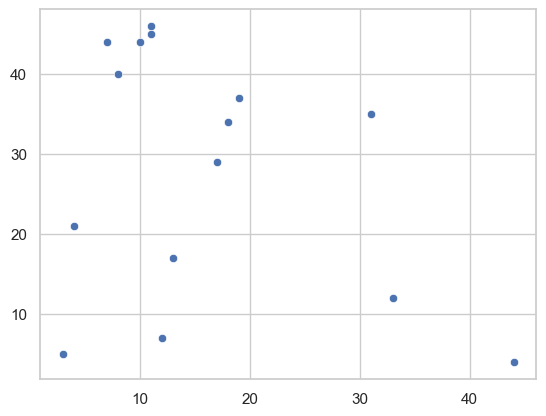

In [46]:
sns.scatterplot(x=x, y=y)

Defining a get_orientation function

In [47]:
def get_orientation(p1, p2, p3):
    '''
    Returns tuple (angle, direction)
    '''
    cross = np.cross(p2 - p1, p3 - p1)
    angle = np.arcsin(cross / (np.linalg.norm(p2-p1) * np.linalg.norm(p3 - p1)))
    if np.isclose(cross, 0):
        return (angle, 'collinear')      # Collinear
    return (angle, 'ccw') if cross > 0 else (angle, 'cw')

Defining an angle function

In [48]:
def angle(u,v):
    a = np.arccos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))
    
    if np.isclose(a, 0):
        return 0
    else:
        return a

In [49]:
points[0][0], points[0][1]

(np.int64(18), np.int64(34))

Demonstration of functioning get_orientation method

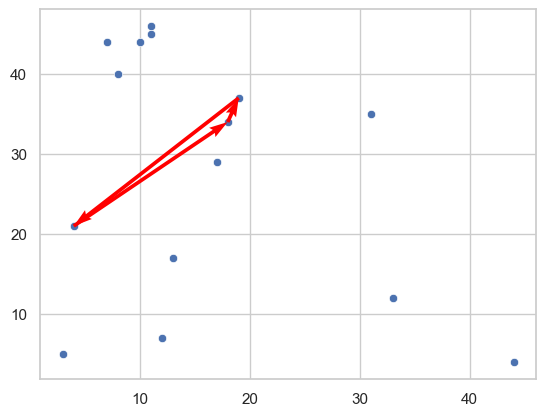

In [50]:
sns.scatterplot(x=x, y=y)

hull_points = [0,4,7]
x = points[hull_points, 0]
y = points[hull_points, 1]

# Calculate vectors (u, v) pointing to the next point
# np.roll shifts the array so we subtract point[i] from point[i+1]
u = np.roll(x, -1) - x
v = np.roll(y, -1) - y

# angles='xy', scale_units='xy', and scale=1 make the arrows 
# exactly as long as the distance between points
plt.quiver(x, y, u, v, color='red', angles='xy', scale_units='xy', scale=1)

In [51]:
val = get_orientation(points[0], points[4], points[7])
val

C:\Users\bisho\AppData\Local\Temp\ipykernel_7936\3243145145.py:5: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(p2 - p1, p3 - p1)


(np.float64(0.5006677248747362), 'ccw')

# Algorithm 1: Slow, Naive

In [52]:
hull_vectors = []

available_points = points.copy()

for i, p in enumerate(available_points):

    for j, q in enumerate(available_points):
        
        if i == j:
            continue

        valid = True

        for k, r in enumerate(available_points):
            
            if k == i or k == j:
                continue
            
            if get_orientation(p, q, r)[1] == 'ccw':
                valid = False
                break
    
            
        if valid:
            print(f"Appending p: {p}, q: {q}")
            hull_vectors.append([p, q])
            

hull_vectors = np.array(hull_vectors)

Appending p: [3 5], q: [ 4 21]
Appending p: [44  4], q: [3 5]
Appending p: [ 7 44], q: [11 46]
Appending p: [ 4 21], q: [ 7 44]
Appending p: [11 46], q: [31 35]
Appending p: [31 35], q: [44  4]


C:\Users\bisho\AppData\Local\Temp\ipykernel_7936\3243145145.py:5: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(p2 - p1, p3 - p1)


<Axes: >

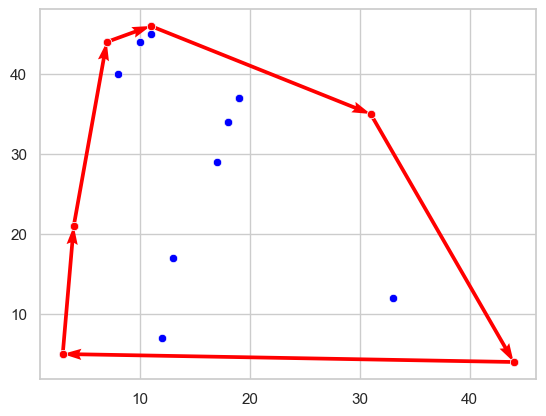

In [53]:
hull_points = np.unique(hull_vectors.reshape(len(hull_vectors) *2,2), axis = 0)

sns.scatterplot(x=x, y=y)

starts = hull_vectors[:, 0]
ends   = hull_vectors[:, 1]

x = starts[:, 0]
y = starts[:, 1]
u = ends[:, 0] - x
v = ends[:, 1] - y


plt.quiver(x, y, u, v, color='red', angles='xy', scale_units='xy', scale=1)
sns.scatterplot(x = points[:, 0], y = points[:,1], color = 'blue')
sns.scatterplot(x = hull_points[:, 0], y = hull_points[:, 1], color = 'red')

This was relatively easy to implement, but the $ O(n^3)$ run-time makes it much slower than other known algorithms. There is a lot of time wasted in the triple loop and this would not scale for larger datasets.

# Algorithm 2: Jarvis March or Gift Wrapping Algorithm

In [54]:
hull_vectors = []

leftmost = np.argmin(points[:, 0])
start = points[leftmost]

current = start
prev_dir = [0, 1]

while True:
    best_angle = -np.inf

    next_point = None

    for p in points:

        if np.array_equal(p, current):
            continue

        v = p - current
        a = angle(prev_dir, v)

        if a > best_angle:
            best_angle = a
            next_point = p

    hull_vectors.append([current, next_point])

    print(f'Prev: {current - prev_dir}, Current: {current}, Next: {next_point}')
    prev_dir = current - next_point

    current = next_point

    if np.array_equal(current, start):
        break
    
hull_vectors = np.array(hull_vectors)

Prev: [3 4], Current: [3 5], Next: [44  4]
Prev: [85  3], Current: [44  4], Next: [31 35]
Prev: [18 66], Current: [31 35], Next: [11 46]
Prev: [-9 57], Current: [11 46], Next: [ 7 44]
Prev: [ 3 42], Current: [ 7 44], Next: [ 4 21]
Prev: [ 1 -2], Current: [ 4 21], Next: [3 5]


C:\Users\bisho\AppData\Local\Temp\ipykernel_7936\787920581.py:2: RuntimeWarning: invalid value encountered in arccos
  a = np.arccos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))


<Axes: >

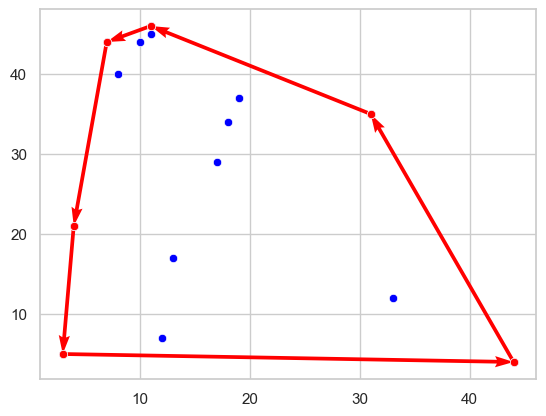

In [55]:
hull_points = np.unique(hull_vectors.reshape(len(hull_vectors) *2,2), axis = 0)

sns.scatterplot(x=x, y=y)

starts = hull_vectors[:, 0]
ends   = hull_vectors[:, 1]

x = starts[:, 0]
y = starts[:, 1]
u = ends[:, 0] - x
v = ends[:, 1] - y


plt.quiver(x, y, u, v, color='red', angles='xy', scale_units='xy', scale=1)
sns.scatterplot(x = points[:, 0], y = points[:,1], color = 'blue')
sns.scatterplot(x = hull_points[:, 0], y = hull_points[:, 1], color = 'red')

# Algorithm 3: Monotone Chain Algorithm